# LSTM Model for IMU Velocity Prediction

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Configuration file paths
imu_file_path = 'data/updated_IMU_front_part1.csv'
velocity_file_path = 'data/updated_velocity_part1.csv'

# Check GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

# Load and process data
imu_data = pd.read_csv(imu_file_path)
velocity_data = pd.read_csv(velocity_file_path)

# Data preprocessing
data = pd.merge(imu_data, velocity_data, on='Time', how='inner')
imu_features = ['ax', 'ay', 'az', 'gx', 'gy', 'gz']
velocity_labels = ['Speed']

scaler = MinMaxScaler()
data[imu_features] = scaler.fit_transform(data[imu_features])
X = data[imu_features].values
y = data[velocity_labels].values

# Data augmentation (adding Gaussian noise + acceleration simulation)
def add_noise(X, noise_level=0.001):
    noise = np.random.normal(0, noise_level, X.shape)
    return X + noise

# Sliding window for constructing time series
def create_time_windows(X, y, window_size=125, step=25):
    X_windows, y_windows = [], []
    for start in range(0, len(X) - window_size, step):
        end = start + window_size
        X_windows.append(X[start:end])
        y_windows.append(y[end - 1])
    return np.array(X_windows), np.array(y_windows)

X = add_noise(X)  # Data augmentation
X_windows, y_windows = create_time_windows(X, y, window_size=125, step=25)
X_train, X_test, y_train, y_test = train_test_split(X_windows, y_windows, test_size=0.2, random_state=42)

# Define LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=3, dropout_rate=0.3):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_rate)
        self.dropout = nn.Dropout(dropout_rate)  # Add Dropout layer
        self.fc = nn.Linear(hidden_size, output_size)
        self.init_weights()

    def init_weights(self):
        for name, param in self.named_parameters():
            if 'weight' in name:
                nn.init.kaiming_normal_(param.data)
            elif 'bias' in name:
                nn.init.constant_(param.data, 0)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.dropout(out[:, -1, :])  # Apply Dropout to the last time step's output
        out = self.fc(out)
        return out

# Hyperparameters
input_size = len(imu_features)
hidden_size = 128
output_size = 1
dropout_rate = 0.3  # Set Dropout probability
batch_size = 32
num_epochs = 150
early_stopping_patience = 20

# Initialize model
model = LSTMModel(input_size, hidden_size, output_size, dropout_rate=dropout_rate).to(device)

# Move data to device
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

# Weighted MSE loss function
def weighted_mse_loss(output, target):
    weight = 1 + target  # Higher speed points have larger weights
    return torch.mean(weight * (output - target) ** 2)

# Optimizer and scheduler
criterion = weighted_mse_loss
optimizer = optim.Adam(model.parameters(), lr=5e-4, weight_decay=1e-5)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

# Training function
def train_one_epoch(model, criterion, optimizer, train_data, batch_size):
    model.train()
    running_loss = 0.0
    for i in range(0, len(train_data[0]), batch_size):
        X_batch = train_data[0][i:i + batch_size]
        y_batch = train_data[1][i:i + batch_size]
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(train_data[0])

# Validation function
def validate_one_epoch(model, criterion, val_data, batch_size):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for i in range(0, len(val_data[0]), batch_size):
            X_batch = val_data[0][i:i + batch_size]
            y_batch = val_data[1][i:i + batch_size]
            val_outputs = model(X_batch)
            val_loss = criterion(val_outputs, y_batch)
            running_loss += val_loss.item()
    return running_loss / len(val_data[0])

# Start training
train_losses, val_losses = [], []
best_val_loss = float('inf')
patience_counter = 0

for epoch in range(num_epochs):
    train_loss = train_one_epoch(model, criterion, optimizer, (X_train_tensor, y_train_tensor), batch_size)
    val_loss = validate_one_epoch(model, criterion, (X_test_tensor, y_test_tensor), batch_size)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    scheduler.step()
    print(f"Epoch {epoch + 1}/{num_epochs} - Train Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        # torch.save(model.state_dict(), 'best_lstm_model.pth')
        torch.save(model.state_dict(), 'best.pth')
    else:
        patience_counter += 1

    if patience_counter >= early_stopping_patience:
        print("Early stopping triggered!")
        break

# Plot loss curves
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.savefig('Training and Validation Loss.svg', format='svg', dpi=300)
plt.show()

Using device: cpu
Epoch 1/150 - Train Loss: 0.3052 - Val Loss: 0.1510
Epoch 2/150 - Train Loss: 0.1176 - Val Loss: 0.1199
Epoch 3/150 - Train Loss: 0.1096 - Val Loss: 0.1147


KeyboardInterrupt: 

# load model and predict

Using device: cuda


C:\Users\dexia\AppData\Local\Temp\ipykernel_18284\3287297759.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('test.pth'))


Length of Time Column: 19998
Length of Smoothed Predictions: 795
Start of Time Column: 3.984
End of Time Column: 83.97200000000001
Generated Time Series Start: 3.984
Generated Time Series End: 83.97200000000001
Mean Squared Error (MSE): 0.4264
Mean Absolute Error (MAE): 0.4317


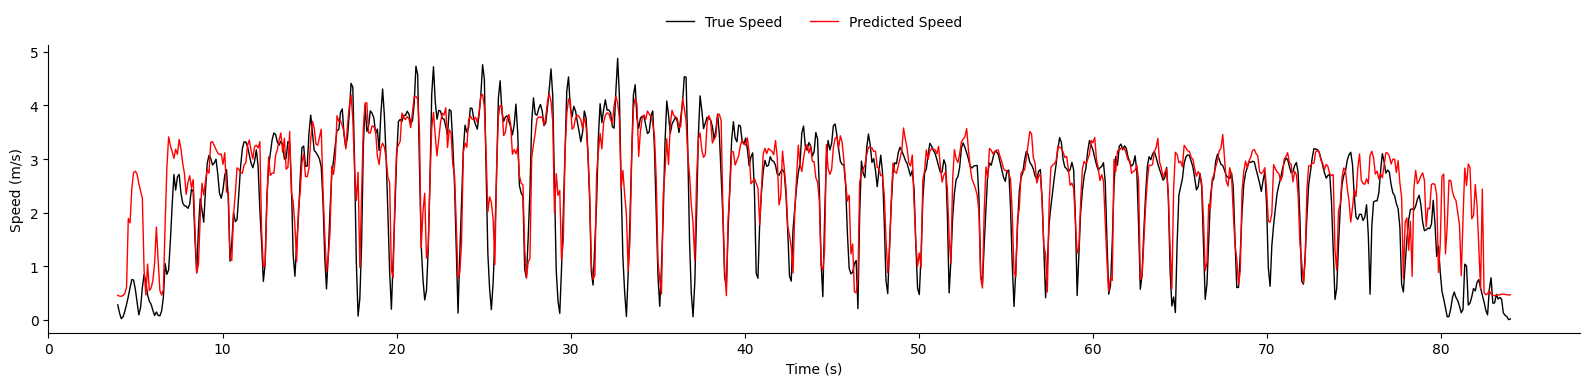

In [18]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Check GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

# Define LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=3):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # Take the output of the last time step
        return out

# Load data
imu_data = pd.read_csv('updated_IMU_front_part1.csv')
velocity_data = pd.read_csv('updated_velocity_part1.csv')

# Merge data
data = pd.merge(imu_data, velocity_data, on='Time', how='inner')
imu_features = ['ax', 'ay', 'az', 'gx', 'gy', 'gz']  # IMU feature columns
velocity_labels = ['Speed']  # Use Speed as the label

# Normalize IMU data
scaler = MinMaxScaler()
data[imu_features] = scaler.fit_transform(data[imu_features])

X = data[imu_features].values  # Input features
y = data[velocity_labels].values  # Output labels

# Sliding window to construct time series
# Adjust the step size to generate more prediction values
def create_time_windows(X, y, window_size=125, step=10):
    X_windows, y_windows = [], []
    for start in range(0, len(X) - window_size, step):
        end = start + window_size
        X_windows.append(X[start:end])
        y_windows.append(y[end - 1])  # Use the last value in the window as the output
    return np.array(X_windows), np.array(y_windows)

X_windows, y_windows = create_time_windows(X, y, window_size=125, step=25)

# Convert to PyTorch tensors
X_tensor = torch.tensor(X_windows, dtype=torch.float32).to(device)
y_tensor = torch.tensor(y_windows, dtype=torch.float32).to(device)

# Load the saved model
input_size = len(imu_features)
hidden_size = 128  # Hidden layer size
output_size = len(velocity_labels)  # Output dimension
model = LSTMModel(input_size, hidden_size, output_size).to(device)
model.load_state_dict(torch.load('test.pth'))
model.eval()  # Set to evaluation mode

# Perform prediction using the model
with torch.no_grad():
    predictions = model(X_tensor)

# Convert predictions and true values to NumPy format
predictions = predictions.cpu().numpy()
y_true = y_tensor.cpu().numpy()

# Smooth predictions using Exponentially Weighted Moving Average (EWMA)
def smooth_predictions_ewma(predictions, alpha=1):
    smoothed = np.zeros_like(predictions)
    smoothed[0] = predictions[0]  # Initialize with the first value
    for t in range(1, len(predictions)):
        smoothed[t] = alpha * predictions[t] + (1 - alpha) * smoothed[t - 1]
    return smoothed

# Apply EWMA to smooth predictions
smoothed_predictions = smooth_predictions_ewma(predictions.flatten(), alpha=1)

# Fix time series generation logic
if len(smoothed_predictions) <= len(data['Time']):
    # Use linear interpolation to generate a time series covering the full time range
    time_series = np.linspace(
        start=data['Time'].iloc[0],  # Start time
        stop=data['Time'].iloc[-1],  # End time
        num=len(smoothed_predictions)  # Match the number of predictions
    )
else:
    # Error handling: The number of predictions exceeds the length of the time column (unlikely scenario)
    raise ValueError("Length of predictions exceeds available time data.")

print(f"Length of Time Column: {len(data['Time'])}")
print(f"Length of Smoothed Predictions: {len(smoothed_predictions)}")
print(f"Start of Time Column: {data['Time'].iloc[0]}")
print(f"End of Time Column: {data['Time'].iloc[-1]}")
print(f"Generated Time Series Start: {time_series[0]}")
print(f"Generated Time Series End: {time_series[-1]}")

# Compute error metrics
mse = mean_squared_error(y_true[len(y_true) - len(smoothed_predictions):], smoothed_predictions)
mae = mean_absolute_error(y_true[len(y_true) - len(smoothed_predictions):], smoothed_predictions)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")

# Visualization comparison
plt.figure(figsize=(16, 4))  # Set width-to-height ratio to match journal requirements

# Plot the true and predicted Speed values
plt.plot(
    time_series, y_true.flatten()[:len(time_series)], 
    label='True Speed', color='black', linewidth=1
)
plt.plot(
    time_series, smoothed_predictions, 
    label='Predicted Speed', color='red', linewidth=1
)

# Axis labels
plt.xlabel('Time (s)', fontsize=10)
plt.ylabel('Speed (m/s)', fontsize=10)

# Legend style: place at the top of the plot
plt.legend(
    fontsize=10, loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=2, frameon=False
)

# Remove unnecessary borders
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.tight_layout()  # Auto-adjust layout
plt.savefig('True vs Predicted Speed 1.svg', format='svg', dpi=600)  # Save high-resolution chart
plt.show()


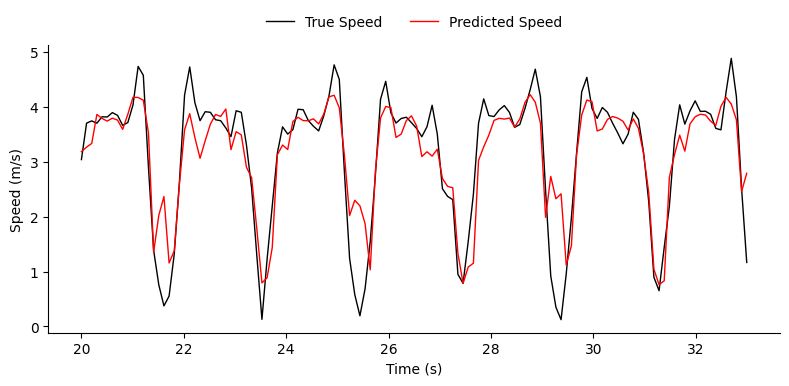

In [19]:
import matplotlib.pyplot as plt

# Extract data in the range of 20 to 33
mask = (time_series >= 20) & (time_series <= 33)
time_series_zoomed = time_series[mask]
y_true_zoomed = y_true.flatten()[:len(time_series)][mask]
smoothed_predictions_zoomed = smoothed_predictions[mask]

# Plotting
plt.figure(figsize=(8, 4))

# Plot the true and predicted Speed values
plt.plot(
    time_series_zoomed, y_true_zoomed, 
    label='True Speed', color='black', linewidth=1
)
plt.plot(
    time_series_zoomed, smoothed_predictions_zoomed, 
    label='Predicted Speed', color='red', linewidth=1
)

# Axis labels
plt.xlabel('Time (s)', fontsize=10)
plt.ylabel('Speed (m/s)', fontsize=10)

# Legend style: place at the top of the plot
plt.legend(
    fontsize=10, loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=2, frameon=False
)

# Remove unnecessary borders
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.tight_layout()  # Auto-adjust layout
plt.savefig('True vs Predicted Speed 2.svg', format='svg', dpi=600)  # Save high-resolution chart
plt.show()


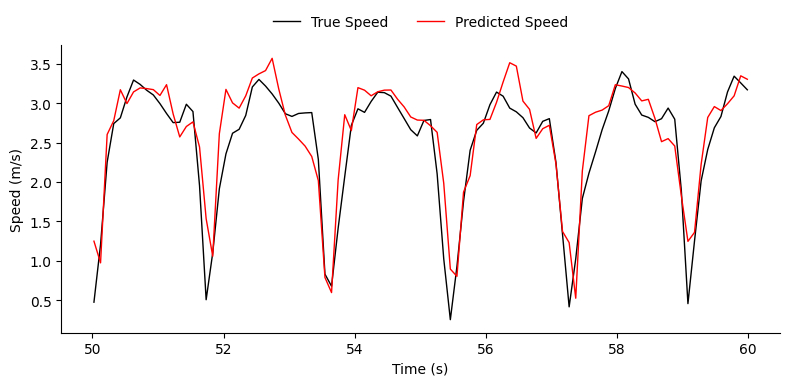

In [20]:
import matplotlib.pyplot as plt

# Extract data in the range of 50 to 60
mask = (time_series >= 50) & (time_series <= 60)
time_series_zoomed = time_series[mask]
y_true_zoomed = y_true.flatten()[:len(time_series)][mask]
smoothed_predictions_zoomed = smoothed_predictions[mask]

# Plotting
plt.figure(figsize=(8, 4))

# Plot the true and predicted Speed values
plt.plot(
    time_series_zoomed, y_true_zoomed, 
    label='True Speed', color='black', linewidth=1
)
plt.plot(
    time_series_zoomed, smoothed_predictions_zoomed, 
    label='Predicted Speed', color='red', linewidth=1
)

# Axis labels
plt.xlabel('Time (s)', fontsize=10)
plt.ylabel('Speed (m/s)', fontsize=10)

# Legend style: place at the top of the plot
plt.legend(
    fontsize=10, loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=2, frameon=False
)

# Remove unnecessary borders
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.tight_layout()  # Auto-adjust layout
plt.savefig('True vs Predicted Speed 3.svg', format='svg', dpi=600)  # Save high-resolution chart
plt.show()


Using device: cuda
Length of Time Column: 15990
Length of Smoothed Predictions: 635
Start of Time Column: 1.992
End of Time Column: 65.94800000000001
Generated Time Series Start: 1.992
Generated Time Series End: 65.94800000000001
Mean Squared Error (MSE): 1.9096
Mean Absolute Error (MAE): 1.0117


C:\Users\dexia\AppData\Local\Temp\ipykernel_18284\3456015189.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('test.pth'))


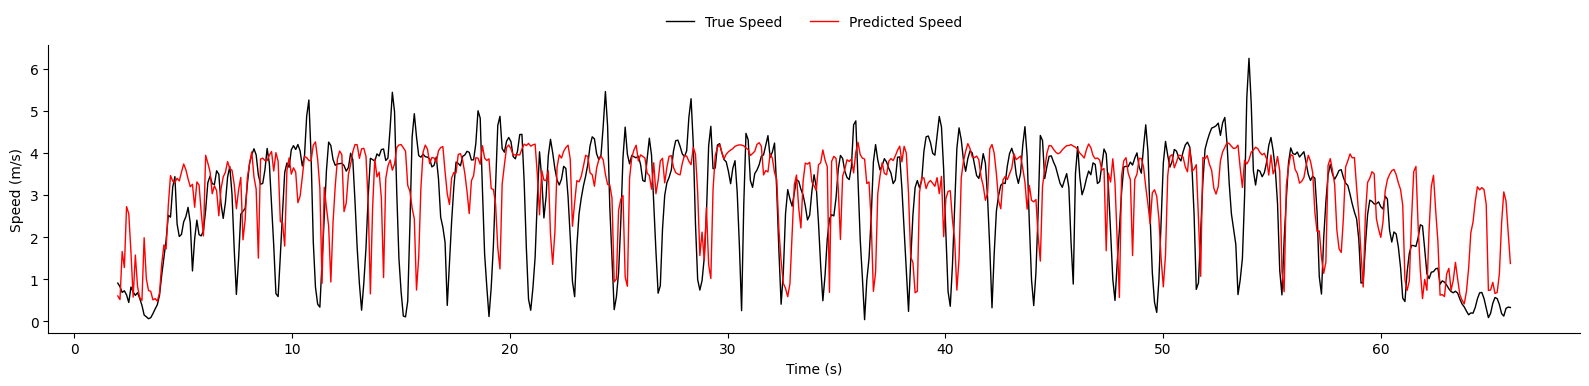

In [21]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Check GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

# Define LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=3):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # Take the output of the last time step
        return out

# Load data
imu_data = pd.read_csv('updated_IMU_front_part2.csv')
velocity_data = pd.read_csv('updated_velocity_part2.csv')

# Merge data
data = pd.merge(imu_data, velocity_data, on='Time', how='inner')
imu_features = ['ax', 'ay', 'az', 'gx', 'gy', 'gz']  # IMU feature columns
velocity_labels = ['Speed']  # Use Speed as the label

# Normalize IMU data
scaler = MinMaxScaler()
data[imu_features] = scaler.fit_transform(data[imu_features])

X = data[imu_features].values  # Input features
y = data[velocity_labels].values  # Output labels

# Sliding window to construct time series
# Adjust the step size to generate more prediction values
def create_time_windows(X, y, window_size=125, step=10):
    X_windows, y_windows = [], []
    for start in range(0, len(X) - window_size, step):
        end = start + window_size
        X_windows.append(X[start:end])
        y_windows.append(y[end - 1])  # Use the last value in the window as the output
    return np.array(X_windows), np.array(y_windows)

X_windows, y_windows = create_time_windows(X, y, window_size=125, step=25)

# Convert to PyTorch tensors
X_tensor = torch.tensor(X_windows, dtype=torch.float32).to(device)
y_tensor = torch.tensor(y_windows, dtype=torch.float32).to(device)

# Load the saved model
input_size = len(imu_features)
hidden_size = 128  # Hidden layer size
output_size = len(velocity_labels)  # Output dimension
model = LSTMModel(input_size, hidden_size, output_size).to(device)
model.load_state_dict(torch.load('test.pth'))
model.eval()  # Set to evaluation mode

# Perform prediction using the model
with torch.no_grad():
    predictions = model(X_tensor)

# Convert predictions and true values to NumPy format
predictions = predictions.cpu().numpy()
y_true = y_tensor.cpu().numpy()

# Smooth predictions using Exponentially Weighted Moving Average (EWMA)
def smooth_predictions_ewma(predictions, alpha=1):
    smoothed = np.zeros_like(predictions)
    smoothed[0] = predictions[0]  # Initialize with the first value
    for t in range(1, len(predictions)):
        smoothed[t] = alpha * predictions[t] + (1 - alpha) * smoothed[t - 1]
    return smoothed

# Apply EWMA to smooth predictions
smoothed_predictions = smooth_predictions_ewma(predictions.flatten(), alpha=1)

# Fix time series generation logic
if len(smoothed_predictions) <= len(data['Time']):
    # Use linear interpolation to generate a time series covering the full time range
    time_series = np.linspace(
        start=data['Time'].iloc[0],  # Start time
        stop=data['Time'].iloc[-1],  # End time
        num=len(smoothed_predictions)  # Match the number of predictions
    )
else:
    # Error handling: The number of predictions exceeds the length of the time column (unlikely scenario)
    raise ValueError("Length of predictions exceeds available time data.")

print(f"Length of Time Column: {len(data['Time'])}")
print(f"Length of Smoothed Predictions: {len(smoothed_predictions)}")
print(f"Start of Time Column: {data['Time'].iloc[0]}")
print(f"End of Time Column: {data['Time'].iloc[-1]}")
print(f"Generated Time Series Start: {time_series[0]}")
print(f"Generated Time Series End: {time_series[-1]}")

# Compute error metrics
mse = mean_squared_error(y_true[len(y_true) - len(smoothed_predictions):], smoothed_predictions)
mae = mean_absolute_error(y_true[len(y_true) - len(smoothed_predictions):], smoothed_predictions)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")

# Visualization comparison
plt.figure(figsize=(16, 4))  # Set width-to-height ratio to match journal requirements

# Plot the true and predicted Speed values
plt.plot(
    time_series, y_true.flatten()[:len(time_series)], 
    label='True Speed', color='black', linewidth=1
)
plt.plot(
    time_series, smoothed_predictions, 
    label='Predicted Speed', color='red', linewidth=1
)

# Axis labels
plt.xlabel('Time (s)', fontsize=10)
plt.ylabel('Speed (m/s)', fontsize=10)

# Legend style: place at the top of the plot
plt.legend(
    fontsize=10, loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=2, frameon=False
)

# Remove unnecessary borders
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.tight_layout()  # Auto-adjust layout
plt.savefig('True vs Predicted Speed 4.svg', format='svg', dpi=600)  # Save high-resolution chart
plt.show()


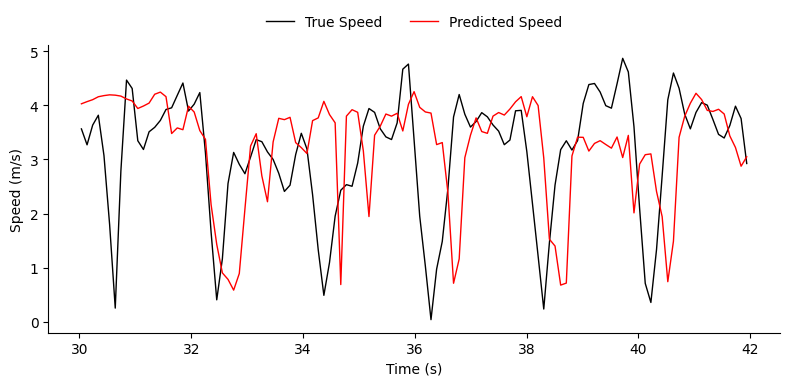

In [22]:
import matplotlib.pyplot as plt

# Extract data in the range of 30 to 42
mask = (time_series >= 30) & (time_series <= 42)
time_series_zoomed = time_series[mask]
y_true_zoomed = y_true.flatten()[:len(time_series)][mask]
smoothed_predictions_zoomed = smoothed_predictions[mask]

# Plotting
plt.figure(figsize=(8, 4))

# Plot the true and predicted Speed values
plt.plot(
    time_series_zoomed, y_true_zoomed, 
    label='True Speed', color='black', linewidth=1
)
plt.plot(
    time_series_zoomed, smoothed_predictions_zoomed, 
    label='Predicted Speed', color='red', linewidth=1
)

# Axis labels
plt.xlabel('Time (s)', fontsize=10)
plt.ylabel('Speed (m/s)', fontsize=10)

# Legend style: place at the top of the plot
plt.legend(
    fontsize=10, loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=2, frameon=False
)

# Remove unnecessary borders
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.tight_layout()  # Auto-adjust layout
plt.savefig('True vs Predicted Speed 5.svg', format='svg', dpi=600)  # Save high-resolution chart
plt.show()


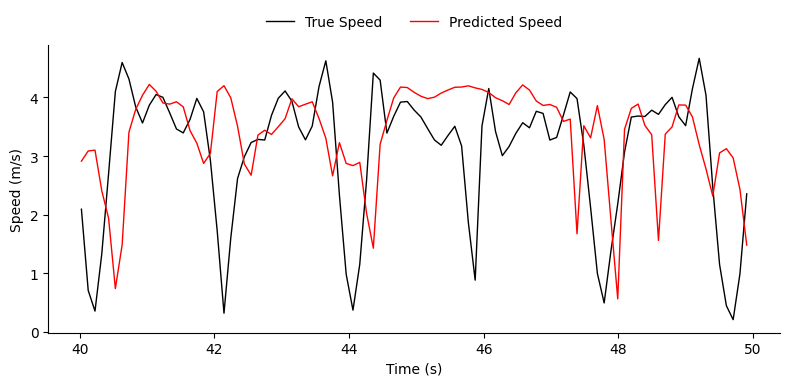

In [23]:
import matplotlib.pyplot as plt

# Extract data in the range of 40 to 50
mask = (time_series >= 40) & (time_series <= 50)
time_series_zoomed = time_series[mask]
y_true_zoomed = y_true.flatten()[:len(time_series)][mask]
smoothed_predictions_zoomed = smoothed_predictions[mask]

# Plotting
plt.figure(figsize=(8, 4))

# Plot the true and predicted Speed values
plt.plot(
    time_series_zoomed, y_true_zoomed, 
    label='True Speed', color='black', linewidth=1
)
plt.plot(
    time_series_zoomed, smoothed_predictions_zoomed, 
    label='Predicted Speed', color='red', linewidth=1
)

# Axis labels
plt.xlabel('Time (s)', fontsize=10)
plt.ylabel('Speed (m/s)', fontsize=10)

# Legend style: place at the top of the plot
plt.legend(
    fontsize=10, loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=2, frameon=False
)

# Remove unnecessary borders
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.tight_layout()  # Auto-adjust layout
plt.savefig('True vs Predicted Speed 6.svg', format='svg', dpi=600)  # Save high-resolution chart
plt.show()
